In [93]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

import segyio
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from shutil import copyfile
from skimage import exposure

import PIL as PIL



In [94]:
filename1 = 'data/Dutch Government_F3_entire_8bit seismic.segy'
seismic = segyio.tools.cube(filename1)

In [95]:
seismic.shape



(651, 951, 462)

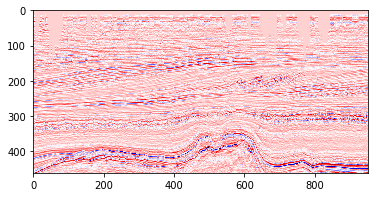

In [96]:

plt.imshow(seismic[300,:,:].T, cmap='seismic')

In [97]:
size = 28

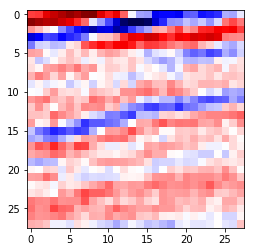

In [98]:
plt.imshow(seismic[300,200:200+size,200:200+size].T, cmap='seismic')

In [99]:
windows = np.zeros((size,size,seismic.shape[0]//size*seismic.shape[2]//size*seismic.shape[1]//size)) # tiles a cross 



In [100]:

j = 0


#for tile in range(0,95*65):

for z in range(0, seismic.shape[1] - size , size):
    for x in range(0, seismic.shape[0] - size , size):
        for y in range(0, seismic.shape[2] - size, size):
            windows[0:size,0:size,j] = seismic[x:x + size,z ,y:y + size]
            j = j + 1

        



In [101]:
windows[:,:,3].shape

(28, 28)

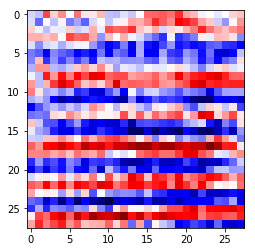

In [102]:
plt.imshow(windows[:,:,6].T,cmap='seismic')

In [103]:




np.save("data/seismic_input_to_autocoder",windows[:,:,0:windows.shape[2]//2])


In [ ]:
# MNIST dataset
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])


x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')